# Working with vector data: Exercise solutions

**Author**: Andrea Ballatore (Birkbeck, University of London)

**Abstract**: Learn how to load, process, and save geospatial vector data using various formats.

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [2]:
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
assert os.environ['CONDA_DEFAULT_ENV'] == 'geoprogv1'
# spatial libraries 
import fiona as fi
import geopandas
import pandas as pd
import pysal as sal
from pyproj import CRS

print('env ok')

Conda env: geoprogv1
env ok


-----
## Exercises

When you are in doubt about how a package or a function work, use the Python website (https://docs.python.org/3.9/) and **Google** to find relevant documentation. `geopandas` is the main package used in these exercises.

### a.
Consider these datasets: world country borders and World Bank indicators. First, remove Antarctica and project the geometries in Eckert IV (plot the geometries to make sure the result is correct). Second, select World Bank data for 2019. Reuse and adapt the code from the lecture.

In [3]:
countries = geopandas.read_file("data/natural_earth_world_boundaries_50m_2018.geojson")
countries = countries[countries.iso_a2 != 'AQ']

# Define projection Eckert IV from https://spatialreference.org/ref/esri/54012/
eckert_IV = CRS.from_proj4("+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
countries = countries.to_crs(eckert_IV)
print("Countries rows:", len(countries))

# load WB data
wb_df = pd.read_csv('data/world_bank_indicators_2014_2019.tsv', sep='\t')
wb19 = wb_df[wb_df.year==2019]
print("WB 2019 rows:", len(wb19))

Countries rows: 240
WB 2019 rows: 264


### b.
With the data produced in the previous step, focus on these two demographic variables in 2019: `sp_pop_0014_to_zs` (percentage of people between 0 and 14 years of age) and `sp_pop_65up_to_zs` (percentage of people 65 or older). Extract only these two indicators to a new data frame (with the country code to identify the country). With the function `merge`, join this data with the country boundaries.

In [5]:
# select columns
age_df = wb19[['country_code','sp_pop_0014_to_zs','sp_pop_65up_to_zs']]
assert len(age_df)>0

# note that countries_df is the main df to enrich with data from age_df
age_countries_df = countries.merge(age_df, left_on="iso_a3", right_on="country_code", how='left')
# check that we haven't lost any country in the merge
assert len(age_countries_df) == len(countries)

# check countries with no age data
noage = age_countries_df[pd.isna(age_countries_df.sp_pop_0014_to_zs)]
# inspect results
noage

,iso_a2,iso_a3,name,name_long,abbrev,type,continent,region_un,subregion,region_wb,un_a3,wb_a2,wb_a3,geometry,country_code,sp_pop_0014_to_zs,sp_pop_65up_to_zs
5,VA,VAT,Vatican,Vatican,Vat.,Sovereign country,Europe,Europe,Southern Europe,Europe & Central Asia,336,-99,-99,"MULTIPOLYGON (((1044787.630 5220518.194, 10440...",NaN,NaN,NaN
10,MH,MHL,Marshall Is.,Marshall Islands,M. Is.,Sovereign country,Oceania,Oceania,Micronesia,East Asia & Pacific,584,MH,MHL,"MULTIPOLYGON (((15913934.736 767727.045, 15912...",MHL,NaN,NaN
11,MP,MNP,N. Mariana Is.,Northern Mariana Islands,N.M.I.,Dependency,Oceania,Oceania,Micronesia,East Asia & Pacific,580,MP,MNP,"MULTIPOLYGON (((13404959.029 2446588.492, 1340...",MNP,NaN,NaN
14,AS,ASM,American Samoa,American Samoa,Am. Samoa,Dependency,Oceania,Oceania,Polynesia,East Asia & Pacific,016,AS,ASM,"MULTIPOLYGON (((-15848821.175 -1879854.821, -1...",ASM,NaN,NaN
17,GS,SGS,S. Geo. and the Is.,South Georgia and the Islands,S.G. & Is.,Dependency,Seven seas (open ocean),Seven seas (open ocean),Seven seas (open ocean),Antarctica,-099,-99,-99,"MULTIPOLYGON (((-1956655.151 -6861972.423, -19...",NaN,NaN,NaN
18,IO,IOT,Br. Indian Ocean Ter.,British Indian Ocean Territory,I.O.T.,Dependency,Seven seas (open ocean),Seven seas (open ocean),Seven seas (open ocean),Sub-Saharan Africa,-099,-99,-99,"MULTIPOLYGON (((6792222.722 -970882.191, 67898...",NaN,NaN,NaN
19,SH,SHN,Saint Helena,Saint Helena,St.H.,Dependency,Seven seas (open ocean),Africa,Western Africa,Sub-Saharan Africa,654,-99,-99,"MULTIPOLYGON (((-526788.726 -2092304.564, -535...",NaN,NaN,NaN
20,PN,PCN,Pitcairn Is.,Pitcairn Islands,Pit. Is.,Dependency,Oceania,Oceania,Polynesia,East Asia & Pacific,612,-99,-99,"MULTIPOLYGON (((-11624541.096 -3157210.421, -1...",NaN,NaN,NaN
21,AI,AIA,Anguilla,Anguilla,Ang.,Dependency,North America,Americas,Caribbean,Latin America & Caribbean,660,-99,-99,"MULTIPOLYGON (((-5803206.456 2377558.085, -581...",NaN,NaN,NaN
22,FK,FLK,Falkland Is.,Falkland Islands,Flk. Is.,Dependency,South America,Americas,South America,Latin America & Caribbean,238,-99,-99,"MULTIPOLYGON (((-4649319.557 -6197231.251, -46...",NaN,NaN,NaN


In [4]:
# no large country is missing, so we know that we have age data for all large countries. 
# We can continue with the analysis!

### c. 
With the data produced in the previous steps, focus on European countries (condition: `continent=='Europe'`). Generate two bar charts: percentage of young people (0-14) in each country, ordered from high to low; percentage of senior people (65+) in each country, ordered from high to low. Use `seaborn` package.

In [9]:
age_europe_df = age_countries_df[age_countries_df.continent=='Europe']
# make sure that the data is not empty
# often, incorrect selections return 0 rows and 
# this stops the analysis because we know that we should have data.
assert len(age_europe_df)>0
len(age_europe_df)

50

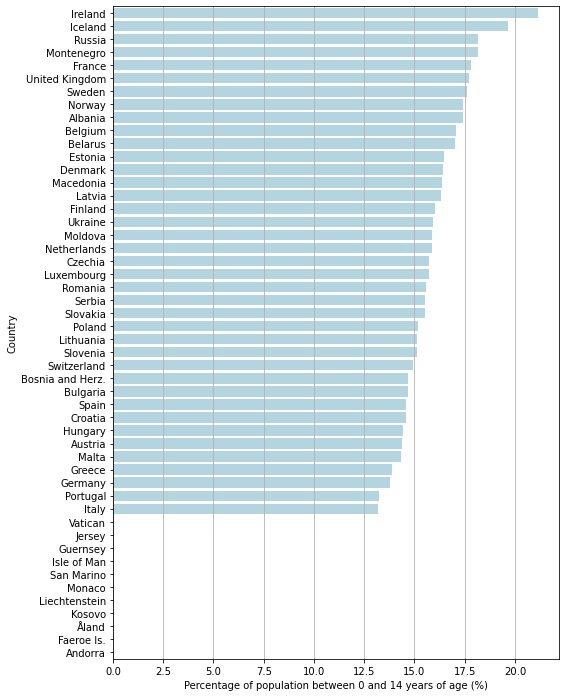

In [10]:
# import packages and set up figure
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,12))

# sort the data. We will keep missing data in the bar chart
age_europe_df = age_europe_df.sort_values('sp_pop_0014_to_zs', ascending=False)

# to pick nice colours, check 
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html

# turn grid lines on
ax = plt.gca()
ax.grid(True)
# simple barchart
sns.barplot(data=age_europe_df, x="sp_pop_0014_to_zs", y="name", color="lightblue")
ax.set(xlabel='Percentage of population between 0 and 14 years of age (%)', ylabel='Country')
# save barchart
plt.savefig('tmp/europe_age0_14_pc_2019_barchart.pdf')

<Figure size 432x288 with 0 Axes>

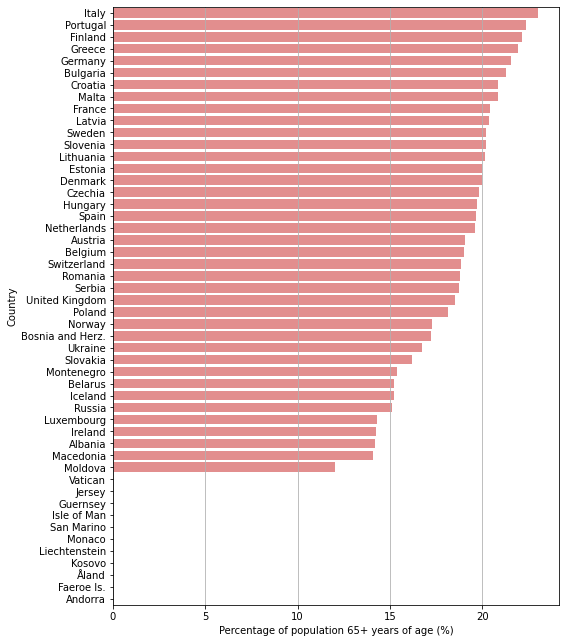

In [11]:
# clear canvas for new plot
plt.clf()

plt.figure(figsize=(8,11))

# sort the data. We will keep missing data in the bar chart
age_europe_df = age_europe_df.sort_values('sp_pop_65up_to_zs', ascending=False)

# turn grid lines on
ax = plt.gca()
ax.grid(True)
# simple barchart
sns.barplot(data=age_europe_df, x="sp_pop_65up_to_zs", y="name", color="lightcoral")
ax.set(xlabel='Percentage of population 65+ years of age (%)', ylabel='Country')
# save barchart
plt.savefig('tmp/europe_age65plus_pc_2019_barchart.pdf')

In [8]:
# we can also combine the two bar charts into a multiple bar chart.
# first re-organise the data in long form 
# (i.e. put the variables on different rows)

df = age_europe_df[['name','country_code','sp_pop_0014_to_zs','sp_pop_65up_to_zs']]

# 'melt' allows to transform the data frame from a wide form (all variables are columns)
# to narrow form (variables are on multiple rows)
age_narrow_df = df.melt(id_vars=['name','country_code'], var_name='age_group', value_name='percentage')
age_narrow_df

,name,country_code,age_group,percentage
0,Italy,ITA,sp_pop_0014_to_zs,13.166658
1,Portugal,PRT,sp_pop_0014_to_zs,13.252085
2,Finland,FIN,sp_pop_0014_to_zs,16.016342
3,Greece,GRC,sp_pop_0014_to_zs,13.896599
4,Germany,DEU,sp_pop_0014_to_zs,13.799488
...,...,...,...,...
95,Liechtenstein,LIE,sp_pop_65up_to_zs,NaN
96,Kosovo,NaN,sp_pop_65up_to_zs,NaN
97,Åland,NaN,sp_pop_65up_to_zs,NaN
98,Faeroe Is.,FRO,sp_pop_65up_to_zs,NaN


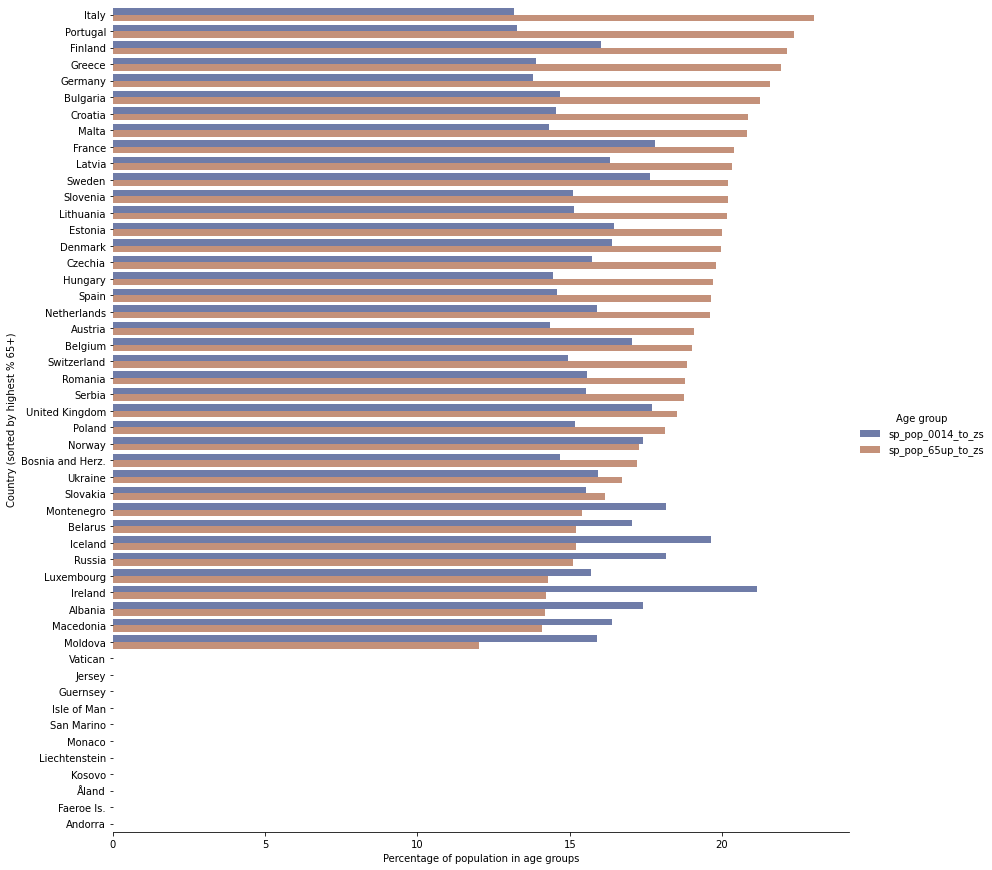

In [9]:
# now we can use age_narrow_df with SeaBorn
g = sns.catplot(
    data=age_narrow_df, kind="bar",
    x="percentage", y="name", hue="age_group",
    palette="dark", alpha=.6, height=12
)
g.despine(left=True)
g.set_axis_labels("Percentage of population in age groups", "Country (sorted by highest % 65+)")
g.legend.set_title("Age group")
plt.savefig('tmp/europe_age_groups_barchart.pdf')

### d. 
With the data produced in the previous steps, plot the distribution of percentage of young and senior people using histograms at the global level. Then produce histograms specific to countries in Europe and Africa. You should produce 6 separate histograms either with `matplotlib` or `seaborn` (see https://seaborn.pydata.org/tutorial/distributions.html).

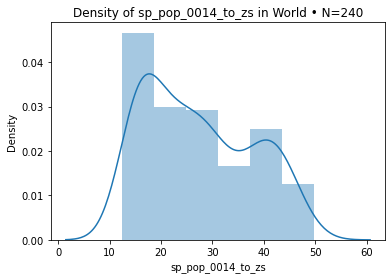

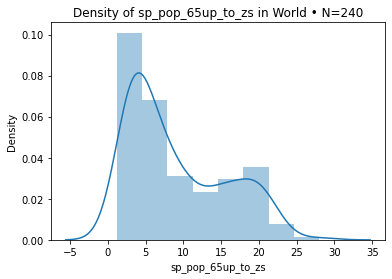

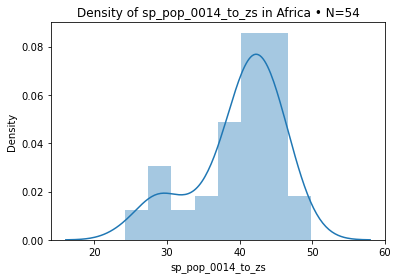

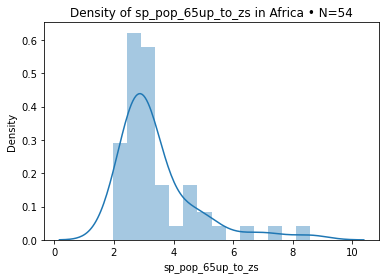

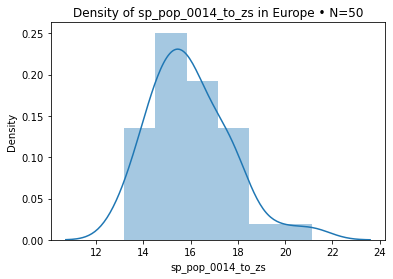

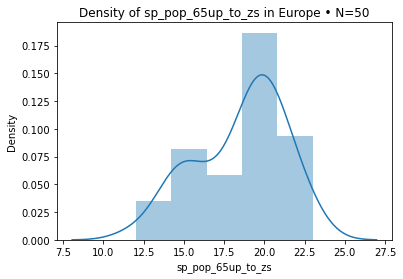

In [10]:
# the data we need is in age_countries_df
df = age_countries_df[['name','country_code','continent','sp_pop_0014_to_zs','sp_pop_65up_to_zs']]

for country_group_name in ['World','Africa','Europe']:
    # select countries
    if country_group_name=='World':
        # keep all
        subdf = df
    else: 
        subdf = df[df.continent==country_group_name]

    # make sure is above 0
    assert len(subdf)>0
        
    for var_name in ['sp_pop_0014_to_zs','sp_pop_65up_to_zs']:
        plt.clf()
        # generate density plot (a fancy histogram)
        sns.distplot(subdf[var_name])
        # set plot title
        plt.title("Density of "+var_name+' in '+country_group_name + " • N="+ str(len(subdf)))
        # save pdf with appropriate name
        plt.savefig('tmp/world_pc_2019_'+var_name+'_'+country_group_name+'_density.pdf')
        # show plot in notebook too
        plt.show()

### e. 
With the data produced in the previous steps, produce two choropleth maps about percentage of young and senior people in countries, using `.plot()` from `geopandas`. Choose colours and binning strategy appropriately. Save the results as PDF in the `tmp` folder.

tmp/world_age_group_choro-sp_pop_0014_to_zs-Blues.pdf


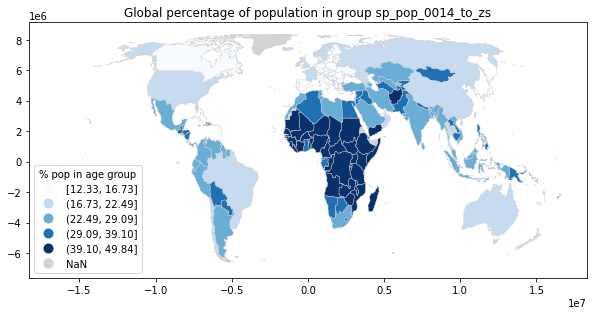

tmp/world_age_group_choro-sp_pop_65up_to_zs-Blues.pdf


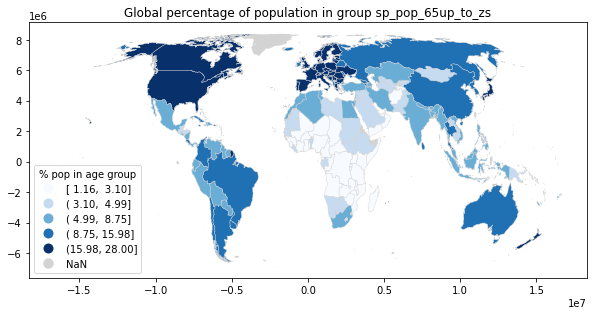

tmp/world_age_group_choro-sp_pop_0014_to_zs-Oranges.pdf


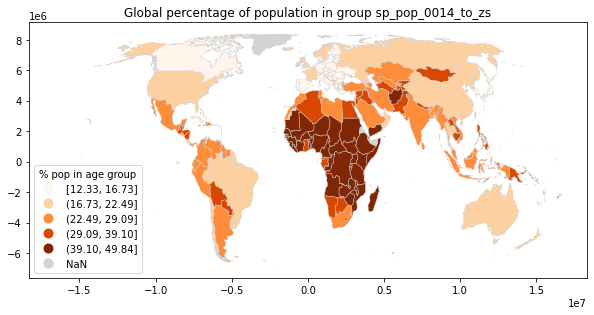

tmp/world_age_group_choro-sp_pop_65up_to_zs-Oranges.pdf


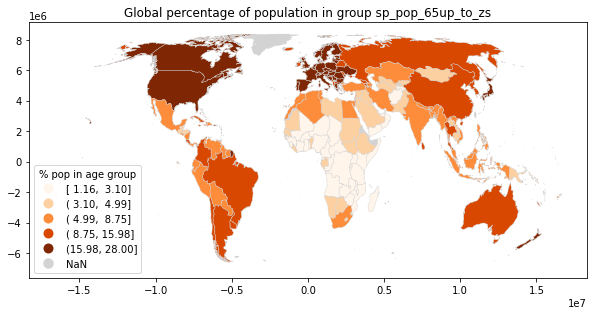

tmp/world_age_group_choro-sp_pop_0014_to_zs-OrRd.pdf


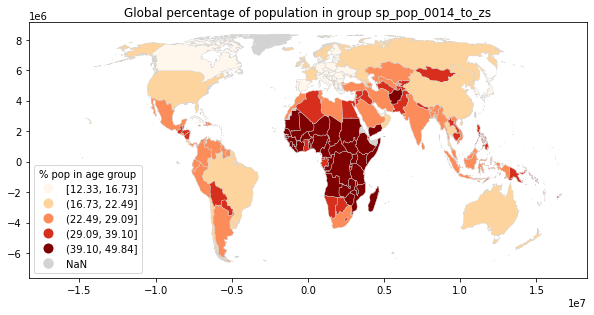

tmp/world_age_group_choro-sp_pop_65up_to_zs-OrRd.pdf


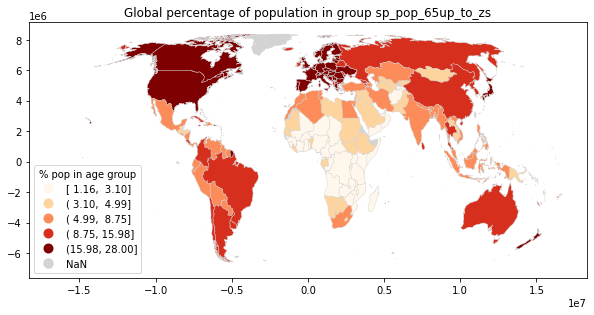

tmp/world_age_group_choro-sp_pop_0014_to_zs-PuBuGn.pdf


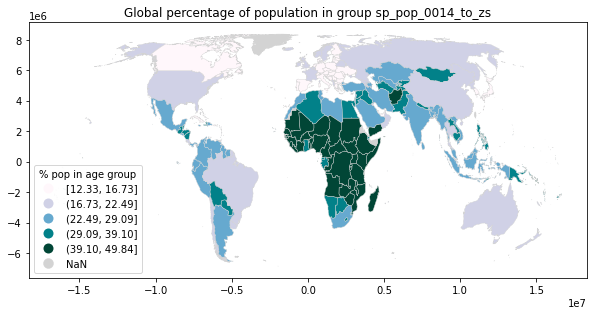

tmp/world_age_group_choro-sp_pop_65up_to_zs-PuBuGn.pdf


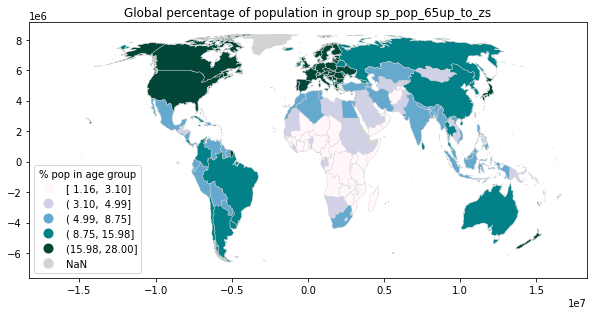

In [11]:
# reuse and modify function from the content notebook
def plot_and_save_choropleth(df, var_name, title, legend_label, colors, file_name):
    """Plot choropleth on variable var_name from geodataframe df"""
    # choropleth with reasonable default settings
    df.plot(column=var_name, scheme='Quantiles', k=5, legend=True, cmap=colors,
        edgecolor="lightgrey", linewidth=0.4,
        legend_kwds={'loc': 'lower left', 'title': legend_label},
        missing_kwds = {'color': "lightgrey"}, figsize=(10,10))
    # set title
    plt.title(title)
    # save and show result
    plt.savefig(file_name)
    plt.show()

# use for loops to generate different combinations of options
for colour_scheme in ['Blues','Oranges','OrRd','PuBuGn']:
    for var_name in ['sp_pop_0014_to_zs','sp_pop_65up_to_zs']:
        # generate title and output file
        plot_title = "Global percentage of population in group "+var_name
        file_out = 'tmp/world_age_group_choro-'+var_name+'-'+colour_scheme+'.pdf'
        print(file_out)
        # call function defined above
        plot_and_save_choropleth(age_countries_df, var_name, plot_title, 
                                 "% pop in age group", colour_scheme, file_out)

### f. 
Using political borders of European countries in 1914, calculate the overlap of the German Empire and the Austro-Hungarian Empire in 1914 with current countries (as of 2018). Use a `for` loop or a function to avoid repeating the same code.

In [12]:
import gzip
europe14_df = geopandas.read_file( gzip.open('data/europe_boundaries_1914.geojson.gz','rb') )
# project to Eckert IV
europe14_df = europe14_df.to_crs(eckert_IV)

# 2018 boundaries
countries2018_df = countries.to_crs(eckert_IV)
# save full area
countries2018_df['area_full_m2'] = countries2018_df.area

europe14_df

,country_id,country_name,geometry
0,1,Albania,"MULTIPOLYGON (((1719453.321 4970484.612, 17191..."
1,2,Austria-Hungary,"MULTIPOLYGON (((1120078.924 5714770.097, 11198..."
2,3,Belgium,"MULTIPOLYGON (((261509.559 6206213.896, 266080..."
3,4,Bulgaria,"MULTIPOLYGON (((2186122.065 5452850.041, 21861..."
4,5,Denmark,"MULTIPOLYGON (((775687.807 6612424.812, 775657..."
5,6,France,"MULTIPOLYGON (((-197398.130 5817725.630, -1980..."
6,7,German Empire,"MULTIPOLYGON (((1416099.041 6533956.121, 14172..."
7,8,Greece,"MULTIPOLYGON (((2073820.666 5169889.009, 20750..."
8,9,Italy,"MULTIPOLYGON (((1068792.851 5723968.041, 10693..."
9,10,Liechtenstein,"MULTIPOLYGON (((774998.996 5793385.834, 775021..."



Studying country Austria-Hungary :
                name  area_intersect_pc
2           Slovakia              100.0
9            Hungary              100.0
13  Bosnia and Herz.               99.7
3           Slovenia               99.5
14           Austria               99.2
11           Czechia               99.0
12           Croatia               98.9
5            Romania               45.3
4             Serbia               28.7
0            Ukraine               11.5
6             Poland               11.2
7         Montenegro                6.4
8              Italy                4.7
10           Germany                0.2
1        Switzerland                0.1

Studying country German Empire :
           name  area_intersect_pc
6       Germany               99.5
2        Poland               47.9
8       Denmark                8.6
5     Lithuania                3.7
10      Belgium                3.0
7        France                2.2
4    Luxembourg                1.9
9       Cz

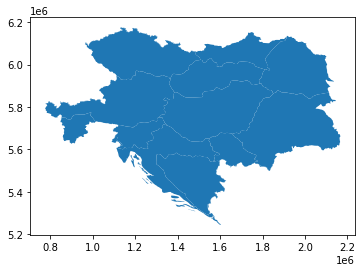

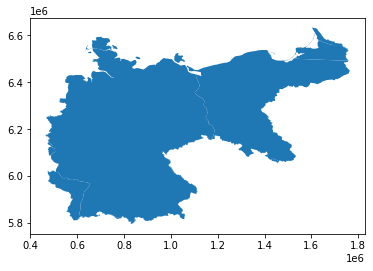

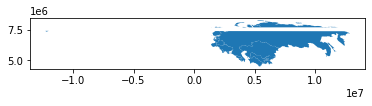

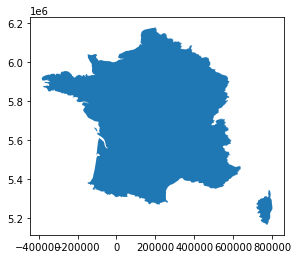

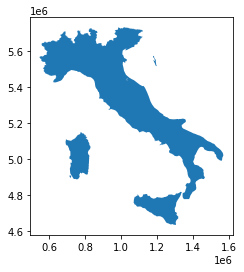

In [13]:
# select countries to study
old_countries_to_study = ['Austria-Hungary','German Empire','Russia','France','Italy']

# this for loop avoid repeating all the following code
for old_country in old_countries_to_study:
    print("\nStudying country ",old_country," in 1914:")
    # get row in spatial data frame
    target_country = europe14_df[europe14_df.country_name==old_country]
    assert len(target_country)==1
    # make the intersection between target country and 2018 countries
    inters_countries18 = geopandas.overlay(target_country, countries2018_df, how='intersection')
    inters_countries18.plot()
    # calculate overlap
    inters_countries18['area_intersect_m2'] = inters_countries18.area
    # select only relevant columns
    inters_countries18 = inters_countries18[['country_name','name','area_intersect_m2','area_full_m2']]
    # calculate percentage
    inters_countries18['area_intersect_pc'] = round(inters_countries18.area_intersect_m2 / inters_countries18.area_full_m2 * 100,1)
    inters_countries18 = inters_countries18.sort_values('area_intersect_pc', ascending=False)
    inters_countries18.to_csv('tmp/overlap_countries_with_'+old_country+'.csv')
    print(inters_countries18[['name','area_intersect_pc']])

### g. 
Plot the results from the previous step as bar charts, sorting them from largest to smallest percentage of overlap (see https://seaborn.pydata.org/generated/seaborn.barplot.html).

Index(['Unnamed: 0', 'country_name', 'name', 'area_intersect_m2',
       'area_full_m2', 'area_intersect_pc'],
      dtype='object')


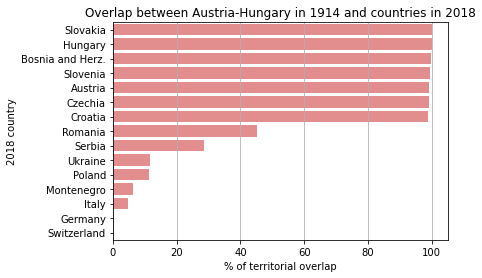

Index(['Unnamed: 0', 'country_name', 'name', 'area_intersect_m2',
       'area_full_m2', 'area_intersect_pc'],
      dtype='object')


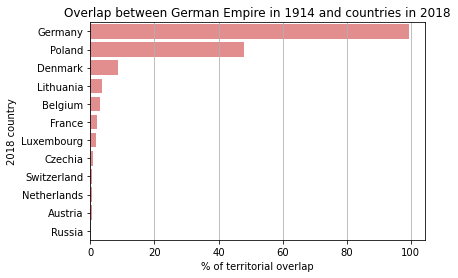

Index(['Unnamed: 0', 'country_name', 'name', 'area_intersect_m2',
       'area_full_m2', 'area_intersect_pc'],
      dtype='object')


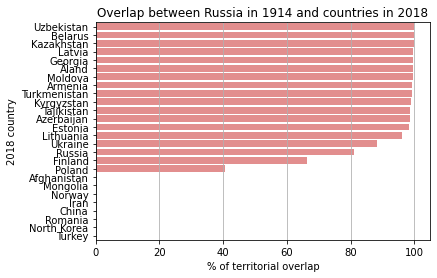

Index(['Unnamed: 0', 'country_name', 'name', 'area_intersect_m2',
       'area_full_m2', 'area_intersect_pc'],
      dtype='object')


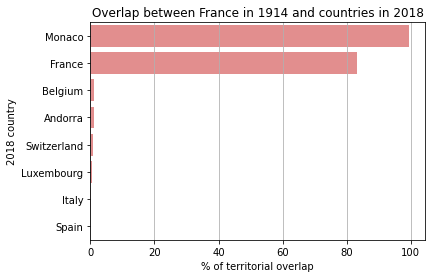

Index(['Unnamed: 0', 'country_name', 'name', 'area_intersect_m2',
       'area_full_m2', 'area_intersect_pc'],
      dtype='object')


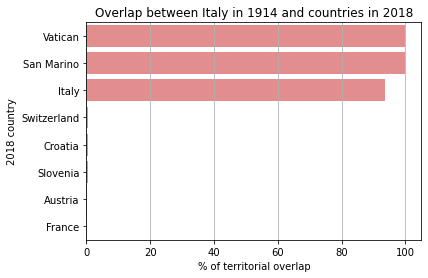

In [14]:
for old_country in old_countries_to_study:
    # read data from files
    filename_base = 'tmp/overlap_countries_with_'+old_country
    # read CSV produced in the previous cell
    df = pd.read_csv(filename_base+'.csv')
    assert len(df)>0
    print(df.columns)
    # sort by area_intersect_pc
    df = df.sort_values('area_intersect_pc', ascending=False)
    # plot bar chart
    ax = plt.gca()
    ax.grid(True)
    # simple barchart
    sns.barplot(data=df, x="area_intersect_pc", y="name", color="lightcoral")
    # set axis labels
    ax.set(xlabel='% of territorial overlap', ylabel='2018 country')
    # set plot title
    plt.title('Overlap between '+old_country+' in 1914 and countries in 2018')
    # save barchart
    plt.savefig(filename_base+'_barchart.pdf')
    plt.show()

End of notebook